# [National Snow and Ice Data Center](https://nsidc.org/data/seaice_index) 

The NSIDC monthly Sea Ice Index provides a quick look at Arctic-wide changes in sea ice. It is a source for consistently processed ice extent and concentration images and data values since 1979. 

In this demo we will explore sea ice .nc data using Xarray. We will interpolate and fit data using SciPy, and make some plots.

# Import essential functions and load ice data using Xarray.

In [13]:
import numpy as np #imports
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
from scipy import stats
import netCDF4
import cmocean

# open dataset here
ice = xr.open_dataset('nsidc_sea_ice_cdr_north.nc')
ice = ice.drop('month')

Text(0.5, 1.0, '2019 Sea Ice Concentration')

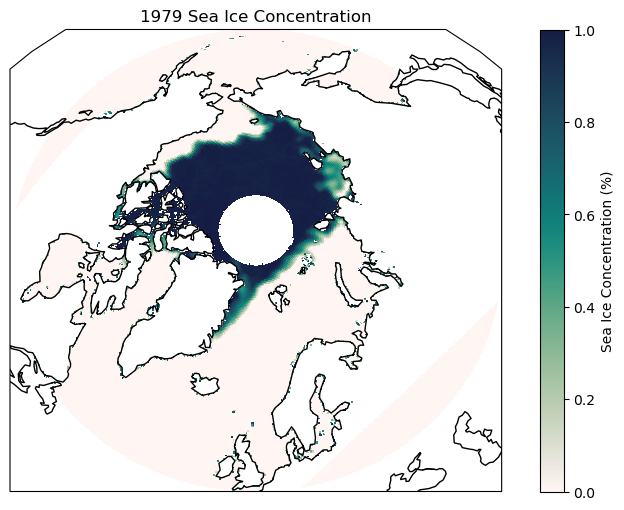

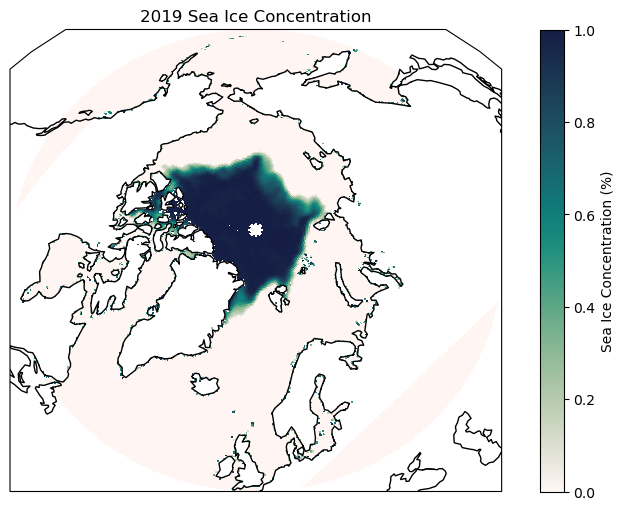

In [96]:
# make a map of Summer 1979
summer_79 = ice['sea_ice_conc'].sel(time = '1979-09').squeeze()
lat_79 = summer_79['lat'].values
lon_79 = summer_79['lon'].values


# make map
# create initial figure with matplotlib
fig = plt.figure(figsize = (10,6))

# add my cartopy features
ax = plt.axes(projection = ccrs.Orthographic(central_longitude=-0.25, central_latitude=70))
ax.coastlines(resolution = '110m', color='black')
# add ssta heat map
plt.pcolormesh(lon_79, lat_79, summer_79, 
               transform=ccrs.PlateCarree(), cmap = cmocean.cm.tempo)
# add a color bar
plt.colorbar(label = u'Sea Ice Concentration (%)')
plt.title('1979 Sea Ice Concentration')



# make a map of Summer 2019
summer_2019 = ice['sea_ice_conc'].sel(time = '2019-09').squeeze()
lat_2019 = summer_2019['lat'].values
lon_2019 = summer_2019['lon'].values


# make map
# create initial figure with matplotlib
fig = plt.figure(figsize = (10,6))

# add my cartopy features
ax = plt.axes(projection = ccrs.Orthographic(central_longitude=-0.25, central_latitude=70))
ax.coastlines(resolution = '110m', color='black')
# add ssta heat map
plt.pcolormesh(lon_2019, lat_2019, summer_2019, 
               transform=ccrs.PlateCarree(), cmap = cmocean.cm.tempo)
# add a color bar
plt.colorbar(label = u'Sea Ice Concentration (%)')
plt.title('2019 Sea Ice Concentration')

## 2D interpolation
Ice data is in 0.5x0.5 resolution. Let's resample and interpolate to 0.25x0.25 resolution!

Text(0.5, 1.0, '1979 Sea Ice Concentration')

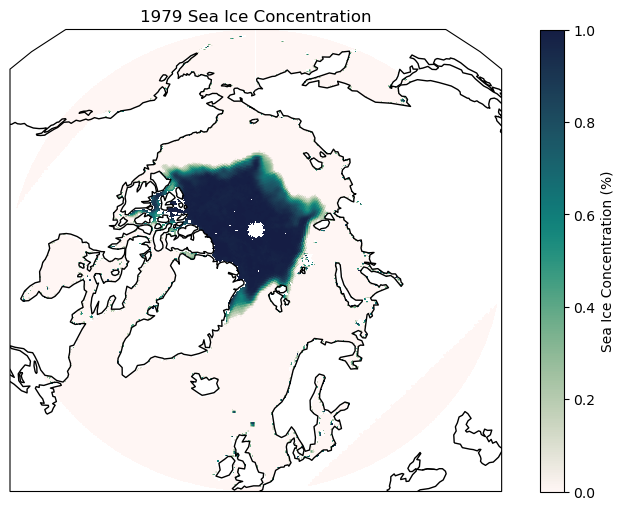

In [134]:
from scipy.interpolate import griddata
# create points
xgrid_79, ygrid_79 = np.meshgrid(lon_2019, lat_2019)
length_values = len(lon_79) * len(lat_79)
# make points
points = np.empty((length_values, 2))
points[:, 0] = xgrid_79.flatten()
points[:, 1] = ygrid_79.flatten()
# make values
values = np.array(summer_2019.values.flatten())

# create new grid
lon_new = np.arange(-180, 180, 0.25)
lat_new = np.arange(50, 90, 0.25)
xgrid_new, ygrid_new = np.meshgrid(lon_new, lat_new)

# create regridded dataset
regrid_79 = griddata(points, values, (xgrid_new, ygrid_new))

# add my cartopy features

# add ssta heat map
plt.figure(figsize=(10,6))
# add my cartopy features
ax = plt.axes(projection = ccrs.Orthographic(central_longitude=-0.25, central_latitude=70))
ax.coastlines(resolution = '110m', color='black')
plt.pcolormesh(lon_new, lat_new, regrid_79, 
               transform=ccrs.PlateCarree(), cmap = cmocean.cm.tempo)

# add a color bar
plt.colorbar(label = u'Sea Ice Concentration (%)')
plt.title('1979 Sea Ice Concentration')

# Let's fit a linear function to the _sloping_ portions of each slice to describe how sea ice coverage varies with latitude.

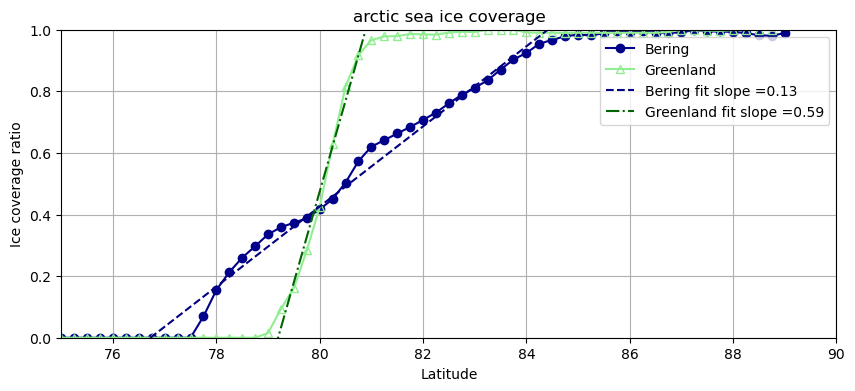

In [130]:
#Get latitudes
lat = ice["lat"].values

# identify summer 
summer_bering = ice["sea_ice_conc"].sel(time = "2019-09",
                                             lon = 169.3, 
                                             method="nearest").values
summer_green = ice["sea_ice_conc"].sel(time = "2019-09",
                                             lon = 0.81, 
                                             method="nearest").values

# define limits of slope
bering_lim = [77,85]
green_lim = [79,81]

#find indexes
bering_inds = np.where((lat > 77) & (lat < 85))
green_inds = np.where((lat > green_lim[0]) & (lat < green_lim[1]))


#Fit linear models
ber_slope, ber_intercept, ber_rvalue, ber_pvalue, ber_sterr = stats.linregress(
    lat[bering_inds],summer_bering[bering_inds])
green_slope, green_intercept, green_rvalue, green_pvalue, green_sterr = stats.linregress(
    lat[green_inds],summer_green[green_inds])


#Make figure with data and lines of best fit, both on the same plot
#Make figure with two series of marker and lines, both on the same plot
fig = plt.figure(figsize=(10,4))
plt.plot(lat,summer_bering,'o-',c="darkblue")
plt.plot(lat,summer_green,'^-',c="lightgreen",markerfacecolor="none")
plt.xlim(75,90)
plt.xlabel("Latitude")
plt.ylabel("Ice coverage ratio")
plt.grid()
plt.title("arctic sea ice coverage")
#add lines of best fit
ber_fit = lat*ber_slope + ber_intercept
green_fit = lat*green_slope + green_intercept
plt.plot(lat,ber_fit,'--',c="navy")
plt.plot(lat,green_fit,'-.',c="darkgreen")
plt.ylim(0,1)
plt.legend(["Bering","Greenland","Bering fit slope =" + str(ber_slope.round(2)),"Greenland fit slope =" + str(green_slope.round(2))])